# **Sentiment Analysis on Vodafone Tweets**

## Introduction

This analysis focuses on performing sentiment analysis on tweets related to Vodafone services. The goal is to identify key themes from customer complaints and interactions through clustering techniques, providing insights into common pain points such as network issues, billing problems, and customer support experiences. The insights generated from this analysis are intended to help Vodafone or other service providers address critical concerns raised by customers, improve their services, and ultimately enhance customer satisfaction.

The dataset used in this analysis consists of tweets directed at Vodafone, collected over a specific time period. Each tweet represents customer feedback, typically in the form of complaints or inquiries about Vodafone's services. By clustering the tweets, similar types of complaints are grouped together, offering a clearer understanding of areas where improvements are needed.

## Dataset Information

The dataset consists of four columns, with each row representing a unique tweet sent to Vodafone. Below is a brief overview of the columns:

### Data Dictionary:

| Column Name   | Description                                                   |
|---------------|---------------------------------------------------------------|
| `username`    | The Twitter handle of the user who sent the tweet              |
| `date`        | The date when the tweet was posted                             |
| `tweet`       | The full text of the tweet containing customer feedback        |
| `mentions`    | The users or companies mentioned in the tweet (e.g., @VodafoneIN) |

A `clean_text` column is also generated during the preprocessing phase, containing a cleaned version of the original `tweet` column, where unwanted characters, mentions, and other unnecessary elements are removed.

## Objective

The primary objective is to analyze and cluster customer feedback from Vodafone-related tweets to uncover the main issues experienced by users. Techniques such as K-Means clustering will be used to categorize these issues into meaningful clusters, which will be visualized using word clouds for better interpretation.


In [1]:
# Mount Google drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
# Import necessary libraries and packages
import pandas as pd
import numpy as np
import requests
import urllib
import re
import nltk

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity= 'all'
from IPython.display import display
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.cluster import KMeans

import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud, ImageColorGenerator
from PIL import Image
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')
warnings.filterwarnings(action= 'ignore', category= DeprecationWarning)

In [3]:
# Load the dataset
df= pd.read_csv('/content/drive/My Drive/tweets.csv', encoding= 'ISO-8859-1')

# View the data
df.head(25)

,username,date,tweet,mentions
0,shivaji_takey,10-06-2020,Please check what happens to this no 940417705...,['vodafonein']
1,sarasberiwala,10-06-2020,Network fluctuations and 4G Speed is pathetic....,['vodafonein']
2,chitreamod,10-06-2020,This has been going on since 3rd... this absol...,['vodafonein']
3,sanjan_suman,10-06-2020,@VodafoneIN I have done my recharge of 555 on...,['vodafonein']
4,t_nihsit,10-06-2020,But when???Still I am not received any call fr...,['vodafonein']
5,tanzeelu3,10-06-2020,@VodafoneIN mere area me vodafone ka network n...,['vodafonein']
6,chitreamod,10-06-2020,"Thanks, but I have visited the website, called...",['vodafonein']
7,mayankpatel7293,10-06-2020,"@VodafoneIN @VodafoneGroup\nHi,\n Today my Vod...","['vodafonein', 'vodafonegroup', 'trai', 'trai_..."
8,deeranjith,10-06-2020,"Dear Vodafone, I have already responded to you...",['vodafonein']
9,govindrathi799,10-06-2020,@VodafoneIN SIR OUR MARKET AREA ME BILKUL NETW...,['vodafonein']


In [4]:
# Explore the data
print('Dataset Columns:', df.columns)
print('Dataset Shape:', df.shape)

Dataset Columns: Index(['username', 'date', 'tweet', 'mentions'], dtype='object')
Dataset Shape: (21047, 4)


In [5]:
# Checking the tweet at index 444 for inspection
df['tweet'][444]

'Can you share me good plan and can tell me how can i port my network operator'

### Importance of Removing @ Mentions in NLP

Removing `@mentions` is a critical step in text preprocessing for NLP tasks, especially in social media data like tweets. Mentions often refer to usernames and do not carry meaningful information related to the overall content or sentiment of the message. By eliminating these extraneous elements, the text is made cleaner and more focused, which improves the quality of downstream tasks such as clustering, topic modeling, and sentiment analysis. This step ensures that irrelevant noise is minimized, leading to more accurate model performance and insights.


In [6]:
# Filter rows with only ASCII characters in the 'tweet' column
df= df[df['tweet'].apply(lambda x: x.isascii())]

# Verify the changes
df['tweet'].head(150)

,tweet
0,Please check what happens to this no 940417705...
1,Network fluctuations and 4G Speed is pathetic....
2,This has been going on since 3rd... this absol...
4,But when???Still I am not received any call fr...
5,@VodafoneIN mere area me vodafone ka network n...
7,"@VodafoneIN @VodafoneGroup\nHi,\n Today my Vod..."
8,"Dear Vodafone, I have already responded to you..."
9,@VodafoneIN SIR OUR MARKET AREA ME BILKUL NETW...
11,Vodafone Netwrk is worst ever...Using from so ...
12,@VodafoneIN 9796053999... internet not working...


In [10]:
# Define a pattern to remove @ mentions
def remove_pattern(input_txt, pattern):

  # Find all occurences of the pattern in the input text
  r= re.findall(pattern, input_txt)

  # Replace each occurence with an empty string (remove it)
  for i in r:
    input_txt= re.sub(i, '', input_txt)

  return input_txt

# Apply the remove_pattern function
df['clean_text']= np.vectorize(remove_pattern)(df['tweet'], '@[\w]*')

# Verify the changes
df['clean_text'].head(150)

,clean_text
0,Please check what happens to this no 940417705...
1,Network fluctuations and 4G Speed is pathetic....
2,This has been going on since 3rd... this absol...
4,But when???Still I am not received any call fr...
5,mere area me vodafone ka network nai aa raha ...
7,"\nHi,\n Today my Vodafone cim is deactivated ..."
8,"Dear Vodafone, I have already responded to you..."
9,SIR OUR MARKET AREA ME BILKUL NETWORK NAHI AA...
11,Vodafone Netwrk is worst ever...Using from so ...
12,"9796053999... internet not working, pls assis..."


In [18]:
# Convert the text to lowercase for consistency
df['clean_text']= df['clean_text'].str.lower()

# Remove words that are 2 characters or shorter
df['clean_text']= df['clean_text'].apply(lambda x: ' '.join([w for w in x.split() if len(w) > 2]))

# Check the new cleaned dataset
df['clean_text'].head()

,clean_text
0,please check what happens this 9404177052 not ...
1,network fluctuations and speed pathetic. need ...
2,this has been going since 3rd... this absolute...
4,but when???still not received any call from cu...
5,mere area vodafone network nai raha hai bhitol...


### Tokenization of Text Data

Tokenization is a crucial step in text preprocessing for NLP tasks. It involves splitting each sentence into individual words or tokens. This process breaks down the text into its fundamental components, enabling more effective analysis.

After tokenization, the tokens are rejoined to ensure consistency in the DataFrame, preparing the text for further transformations such as vectorization and clustering. Tokenization helps in identifying patterns, relationships between words, and improving model accuracy in NLP tasks.


In [19]:
# Tokenize the 'clean_text' column
df['tokenized_text']= df['clean_text'].apply(lambda x: x.split())

# Rejoin the tokens back into sentences
df['clean_text']= df['tokenized_text'].apply(' '.join)

# Remove the temporary 'tokenized_text'
df= df.drop('tokenized_text', axis= 1)

# Verify changes
df['clean_text'].head(10)

,clean_text
0,please check what happens this 9404177052 not ...
1,network fluctuations and speed pathetic. need ...
2,this has been going since 3rd... this absolute...
4,but when???still not received any call from cu...
5,mere area vodafone network nai raha hai bhitol...
7,"hi, today vodafone cim deactivated without any..."
8,"dear vodafone, have already responded your rep..."
9,sir our market area bilkul network nahi raha h...
11,vodafone netwrk worst ever...using from many y...
12,"9796053999... internet not working, pls assist..."


In [20]:
# Drop duplicate rows based on 'clean_text' and reset the index
df.drop_duplicates(subset= ['clean_text'], keep= 'first', inplace= True)
df.reset_index(drop= True, inplace= True)

# Add a column that contains the lenght of the 'clean_text'
df['clean_text_length']= df['clean_text'].apply(len)

# Check the first few rows to confirm changes
df.head()

,username,date,tweet,mentions,clean_text,clean_text_length
0,shivaji_takey,10-06-2020,Please check what happens to this no 940417705...,['vodafonein'],please check what happens this 9404177052 not ...,81
1,sarasberiwala,10-06-2020,Network fluctuations and 4G Speed is pathetic....,['vodafonein'],network fluctuations and speed pathetic. need ...,80
2,chitreamod,10-06-2020,This has been going on since 3rd... this absol...,['vodafonein'],this has been going since 3rd... this absolute...,64
3,t_nihsit,10-06-2020,But when???Still I am not received any call fr...,['vodafonein'],but when???still not received any call from cu...,77
4,tanzeelu3,10-06-2020,@VodafoneIN mere area me vodafone ka network n...,['vodafonein'],mere area vodafone network nai raha hai bhitol...,84


In [21]:
# Filter tweets from the user omanmessi for inspection
df[df['username'] == 'omanmessi']

,username,date,tweet,mentions,clean_text,clean_text_length
15,omanmessi,10-06-2020,@VodafoneIN,"['ooredoooman', 'vodafonein']",,0


In [22]:
# Filter out rows where 'clean_text' column has no content (length= 0)
df[df['clean_text_length'] == 0]['clean_text']

# Identify the index of rows with empty 'clean_text'
indexes= df[df['clean_text_length'] == 0]['clean_text'].index

,clean_text
15,


In [23]:
# Drop the rows where 'clean_text' is empty
df.drop(index= indexes, inplace= True)

# Display the DataFrame info
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 16194 entries, 0 to 16194
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   username           16194 non-null  object
 1   date               16194 non-null  object
 2   tweet              16194 non-null  object
 3   mentions           16194 non-null  object
 4   clean_text         16194 non-null  object
 5   clean_text_length  16194 non-null  int64 
dtypes: int64(1), object(5)
memory usage: 885.6+ KB


In [24]:
# Reset the index of the DataFrame after removing rows
df.reset_index(drop= True, inplace= True)

# Display the DataFrame info to confirm changes
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16194 entries, 0 to 16193
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   username           16194 non-null  object
 1   date               16194 non-null  object
 2   tweet              16194 non-null  object
 3   mentions           16194 non-null  object
 4   clean_text         16194 non-null  object
 5   clean_text_length  16194 non-null  int64 
dtypes: int64(1), object(5)
memory usage: 759.2+ KB


In [25]:
# Show the first few rows of the 'clean_text' column
df['clean_text'].head()

,clean_text
0,please check what happens this 9404177052 not ...
1,network fluctuations and speed pathetic. need ...
2,this has been going since 3rd... this absolute...
3,but when???still not received any call from cu...
4,mere area vodafone network nai raha hai bhitol...


### Vectorization of Text Data

Vectorization is the process of converting text data into a numerical format, which is essential for machine learning models to process textual information. In this step, the `CountVectorizer` is used to transform the cleaned text into a document-term matrix, where each row represents a document (tweet) and each column represents a unique word. The matrix contains word counts, allowing the model to analyze the frequency of words across different tweets.

Key parameters include:
- **ngram_range=(1,1)**: Considering single words (unigrams) only.
- **stop_words='english'**: Common English words (like "the", "is") are removed.
- **min_df=0.0001**: Ignores words that appear in less than 0.01% of the documents.
- **max_df=0.7**: Excludes words that appear in more than 70% of the documents.

This vectorization step is essential for converting raw text into a format that machine learning models can understand and work with effectively.


In [26]:
# Initialize the CountVectorizer
vect= CountVectorizer(analyzer= 'word', ngram_range= (1,1), stop_words= 'english', min_df= 0.0001, max_df= 0.7)

# Fit the vectorizer to the 'clean_text' and transform it into a document-term matrix
vect.fit(df['clean_text'])
dt_matrix= vect.transform(df['clean_text'])

# Inspect the document-term matrix
dt_matrix.toarray()
dt_matrix.shape

CountVectorizer(max_df=0.7, min_df=0.0001, stop_words='english')

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

(16194, 6266)

### K-Means Clustering for Text Data

K-Means clustering is an essential technique in unsupervised machine learning, particularly effective for discovering patterns and grouping similar data points. In the context of text data, K-Means helps in identifying underlying topics or themes by clustering similar documents together based on their content.

The decision to use **K-Means** is driven by its simplicity and efficiency, especially when dealing with large datasets. K-Means works by iteratively assigning data points to the nearest cluster center and adjusting the centers until convergence. This makes it well-suited for high-dimensional data, such as the document-term matrix generated from text.

In this case, **2 clusters** are chosen to segment the tweets into two distinct groups. The number of clusters (K) is often determined based on the structure of the data and the specific objectives of the analysis. Here, 2 clusters might represent two broad themes or categories within the tweets, such as positive and negative sentiments, or different types of topics. This choice can always be adjusted depending on the complexity of the data and the results from exploratory analysis.

K-Means is particularly useful because it effectively handles the sparse nature of document-term matrices and produces interpretable clusters that can be used for further analysis or insights.


In [27]:
# Initialize the K-Means model and fit it to the document-term matrix
num_clusters= 2
km= KMeans(n_clusters= num_clusters)
km.fit(dt_matrix)

KMeans(n_clusters=2)

In [28]:
# Extract cluster labels and create a DataFrame with tweets and their corresponding clusters
clusters= km.labels_.tolist()
tweets= {'Tweet': df['clean_text'].tolist(), 'Cluster': clusters}
frame= pd.DataFrame(tweets, index= clusters)

# Inspect the DataFrame
frame.head()

,Tweet,Cluster
1,please check what happens this 9404177052 not ...,1
1,network fluctuations and speed pathetic. need ...,1
1,this has been going since 3rd... this absolute...,1
1,but when???still not received any call from cu...,1
1,mere area vodafone network nai raha hai bhitol...,1


In [29]:
# Check distribution of clusters
frame['Cluster'].value_counts()

,count
Cluster,
1,13935
0,2259


In [30]:
# Extract tweets from cluster 0
cluster_0= frame[frame['Cluster'] == 0]
cluster_0

,Tweet,Cluster
0,super fast 4g+ network... thank you pic.twitte...,0
0,you can't provide the speed sufficient network...,0
0,this happening since morning and happens every...,0
0,"this your internet speed, complaining again ag...",0
0,did not subscribe for any re.1 service!! didn'...,0
0,again network. porting out. pic.twitter.com/uw...,0
0,response from your end. don't know why you peo...,0
0,dear finally some how got message for your tea...,0
0,here comes the standard reply. your customer c...,0
0,"not getting any store, call email solutions de...",0


In [31]:
# Function to generate a word cloud visualization for a specific cluster
def wordcloud(cluster):

  # Load the twitter logo to shape the word cloud
  Mask= np.array(Image.open(requests.get('http://clipart-library.com/image_gallery2/Twitter-PNG-Image.png', stream= True).raw))

  # Use ImageColorGenerator to extract colors from the mask image
  image_colors= ImageColorGenerator(Mask)

  # Generate the word cloud
  wc= WordCloud(background_color= 'black', height= 1500, width= 4000, mask= Mask).generate(cluster)

  # WordCloud plot
  plt.figure(figsize= (10,20))
  plt.imshow(wc.recolor(color_func= image_colors), interpolation= 'hamming')
  plt.axis('off')
  plt.show()

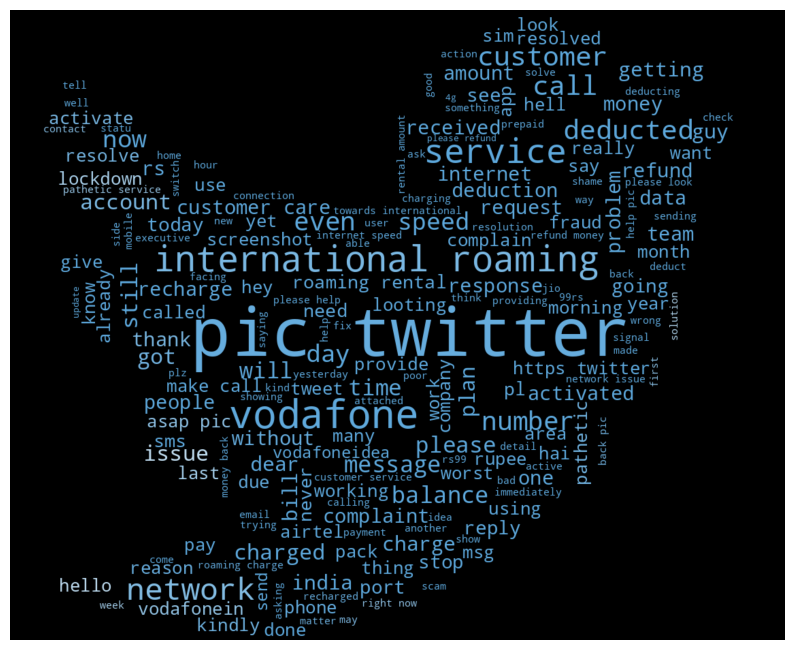

In [32]:
# Concatenate all words in Cluster 0 into a single string
cluster_0_words= ' '.join(text for text in cluster_0['Tweet'])

# Generate a word cloud for Cluster 0
wordcloud(cluster_0_words)

### Word Cloud for Cluster 1

This word cloud visualization represents the most frequent terms in the tweets belonging to **Cluster 1**. The larger the word appears, the more frequently it occurs in the dataset.

Key terms such as **"twitter," "vodafone," "service," "network," "pic," and "international roaming"** appear prominently, indicating common themes and issues within the cluster. These words suggest that customers are frequently discussing network-related problems, service quality, and issues with international roaming.

Other notable terms like **"deduction," "balance," "activated," "bill,"** and **"complain"** emphasize recurring topics related to customer complaints about billing, activation, and service issues.




In [33]:
# Filter the tweets in Cluster 1
cluster_1= frame[frame['Cluster'] == 1]

# Display the filtered tweets
cluster_1.head(10)

,Tweet,Cluster
1,please check what happens this 9404177052 not ...,1
1,network fluctuations and speed pathetic. need ...,1
1,this has been going since 3rd... this absolute...,1
1,but when???still not received any call from cu...,1
1,mere area vodafone network nai raha hai bhitol...,1
1,"hi, today vodafone cim deactivated without any...",1
1,"dear vodafone, have already responded your rep...",1
1,sir our market area bilkul network nahi raha h...,1
1,vodafone netwrk worst ever...using from many y...,1
1,"9796053999... internet not working, pls assist...",1


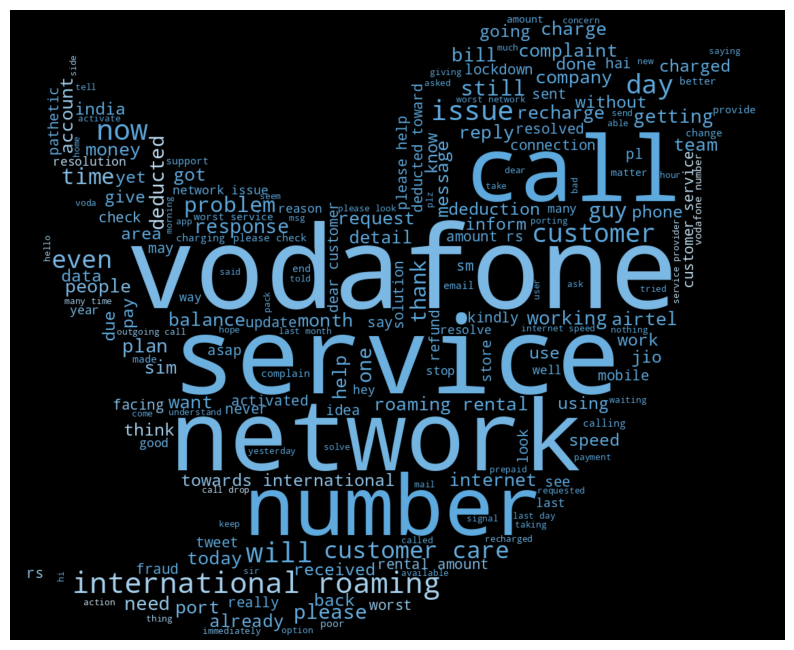

In [34]:
# Join the tweets from Cluster 1 into a single string
cluster_1_words= ' '.join(text for text in cluster_1['Tweet'])

# Generate the word cloud for Cluster 1
wordcloud(cluster_1_words)

### Word Cloud for Cluster 1

This word cloud visualization represents the most frequently occurring words in the tweets belonging to **Cluster 1**. Key terms like **"vodafone," "service," "network," "call," "number,"** and **"customer care"** appear prominently, suggesting recurring topics of customer complaints about network issues, service quality, and contact with customer care.

Additional words such as **"international roaming," "deduction," "activated,"** and **"recharge"** point to a variety of concerns regarding roaming services, balance deductions, and recharging issues.

However, unlike Cluster 1, the topics in Cluster 0 appear more scattered and less cohesive. There seems to be a wide range of different issues being discussed, making it difficult to identify a single overarching theme. This suggests that the cluster contains a broader variety of topics, and a more detailed clustering approach might be needed to separate these issues into more focused topics.


In [35]:
# Update the number of clusters
num_clusters= 6
km= KMeans(n_clusters= num_clusters)
km.fit(dt_matrix)

# Assign clusters to the DataFrame
clusters= km.labels_.tolist()
tweets= {'Tweets': df['clean_text'].tolist(), 'Cluster': clusters}
frame= pd.DataFrame(tweets)

KMeans(n_clusters=6)

In [36]:
# View the DataFrame
frame.head()

,Tweets,Cluster
0,please check what happens this 9404177052 not ...,3
1,network fluctuations and speed pathetic. need ...,5
2,this has been going since 3rd... this absolute...,3
3,but when???still not received any call from cu...,3
4,mere area vodafone network nai raha hai bhitol...,5


In [37]:
# Check distribution of clusters
frame['Cluster'].value_counts()

,count
Cluster,
3,7722
2,2343
5,2278
1,2100
0,1232
4,519


In [40]:
# Generate word clouds for each cluster
for i in range(num_clusters):
  cluster= frame[frame['Cluster'] == i]
  cluster_words= ' '.join(text for text in cluster['Tweets'])

  print(f'Word Cloud for Cluster {i}:')
  wordcloud(cluster_words)

Output hidden; open in https://colab.research.google.com to view.

### Analysis: 6 Clusters vs. 2 Clusters

When comparing the 6-cluster word clouds against the 2-cluster approach, it becomes evident that clustering into 6 groups offers a much more granular view of customer complaints and service issues. The 2-cluster method, while useful for an initial overview, tends to produce broader categories that sometimes overlap significantly. By contrast, the 6-cluster method allows us to see more specific and distinct themes.

1. **Cluster 0 (6-cluster)**:
   The predominant words such as "international roaming," "rental," and "deducted" indicate that this cluster is centered around issues related to roaming charges and international services. This provides clarity on customers facing billing problems during international travel, as well as frustrations over unexpected charges.

2. **Cluster 1 (6-cluster)**:
   This cluster is characterized by words such as "service," "network," "call," and "customer care." It highlights general network and service-related issues, with specific concerns regarding poor customer support. The volume of words related to "call" and "network" indicates frequent complaints about dropped calls and unreliable connectivity.

3. **Cluster 2 (6-cluster)**:
   In this cluster, common terms like "network," "issue," and "internet" suggest a focus on technical problems, particularly regarding poor network quality and slow internet speeds. The prominence of these terms suggests that a significant portion of customers are dissatisfied with the technical performance of Vodafone services.

4. **Cluster 3 (6-cluster)**:
   This cluster revolves around billing issues, with frequent mentions of "bill," "deducted," and "amount." It reveals specific frustrations with incorrect billing, unexpected charges, and difficulties getting refunds or corrections. This level of specificity is less visible in the 2-cluster method.

5. **Cluster 4 (6-cluster)**:
   Words like "port," "number," and "network issue" dominate this cluster. These terms suggest concerns over switching networks (porting) and network problems during the process of changing service providers, making it clear that many customers are seeking alternatives due to dissatisfaction.

6. **Cluster 5 (6-cluster)**:
   This cluster emphasizes interactions with customer service. Words like "customer," "service," and "complaint" reveal ongoing frustration with customer support systems, ranging from delayed responses to unresolved issues after multiple complaints.

While the 2-cluster analysis provides a broad overview of customer issues, dividing the data into 6 clusters adds significantly more detail. The 6-cluster approach highlights specific recurring problems in categories such as billing, customer service, technical issues, and international services. This finer level of detail allows for more targeted interventions and a deeper understanding of customer pain points, offering valuable insights for improving Vodafone’s service.

### Importance for Business

The ability to identify specific themes from customer feedback through clustering can significantly impact a business's decision-making process. By understanding the exact areas where customers are experiencing issues—whether it’s with billing, network quality, or customer service—companies like Vodafone can take targeted action to resolve these concerns. This approach allows businesses to prioritize improvements where they are needed most, enhancing customer satisfaction and reducing churn. Furthermore, having detailed insights into customer pain points helps in designing better communication strategies, improving customer retention, and strengthening overall brand loyalty. In today’s competitive environment, identifying and addressing these issues is crucial for long-term business success.
